In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
df_600=pd.DataFrame()
df_600=pd.read_csv("600.csv")
df_fake=pd.DataFrame()

df_60=pd.DataFrame()
df_60=pd.read_csv("60.csv")

In [3]:
# Split the dataset into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(df_60, df_600, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

# Convert the data to PyTorch tensors
x_train = torch.tensor(x_train.values).float()
y_train = torch.tensor(y_train.values).float()
x_val = torch.tensor(x_val.values).float()
y_val = torch.tensor(y_val.values).float()
x_test = torch.tensor(x_test.values).float()
y_test = torch.tensor(y_test.values).float()


In [4]:
# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
#print(torch.cuda.get_device_name(0))

Using cpu device


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(5500, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 2048)
        self.fc6 = nn.Linear(2048, 4096)
        self.fc7 = nn.Linear(4096, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = nn.functional.relu(self.fc5(x))
        x = nn.functional.relu(self.fc6(x))
        x = self.fc7(x)
        x = torch.sigmoid(x)
        return x


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(5500, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 2048)
        self.fc6 = nn.Linear(2048, 4096)
        self.fc7 = nn.Linear(4096, 5500)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = nn.functional.relu(self.fc5(x))
        x = nn.functional.relu(self.fc6(x))
        x = self.fc7(x)
        return x

In [7]:
discriminator_lr=0.001
generator_lr=0.001
        
generator=Generator()
discriminator=Discriminator()       
        
d_optimizer = optim.Adam(discriminator.parameters(), lr=discriminator_lr)
g_optimizer = optim.Adam(generator.parameters(), lr=generator_lr)
loss = nn.BCELoss()
        


        
        # Define the loss function and optimizer
criterion_model = nn.MSELoss()
optimizer_model = torch.optim.Adam(generator.parameters(), lr=0.001)

        # Train the model
train_losses = []
val_losses = []
d_losses = []
g_losses = []
batch_size=8
epoches=500

for epo in range(epoches):
    
    file=f"fake_data/fake_data_{epo}.csv"
    df_fake=pd.read_csv("fake_data.csv")
    data_f=torch.tensor(df_fake.values).float()
    
    
    for i in range(0, x_train.shape[0], batch_size):
        
        # Get the batch
        batch_x = x_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
                    
                # Zero the parameter gradients
        optimizer_model.zero_grad()

                # Forward pass
        outputs = generator(batch_x)

                # Compute the loss
        train_loss = criterion_model(outputs, batch_y)

                # Backward pass and optimize
        train_loss.backward(retain_graph=True)
        optimizer_model.step()
        
        #Train Discriminator
        d_optimizer.zero_grad()
        real_labels = torch.ones(batch_y.size(0), 1)
        fake_labels = torch.zeros(20, 1)

        # Train discriminator on real data
        real_output = discriminator(batch_y)
        loss_real=loss(real_output, real_labels)
        real_loss =loss_real.mean().item()

        # Train discriminator on fake data generated by generator
        noise = data_f
        fake_data = noise #self.generator(noise)
        fake_output = discriminator(fake_data)
        loss_fake=loss(fake_output, fake_labels)
        fake_loss =loss_fake.mean().item()
        
        # Compute total discriminator loss and backpropagate
        total_loss = loss_real + loss_fake
        total_loss.backward()
        d_optimizer.step()
        d_losses.append(total_loss.item())
        
        #train generator
        g_optimizer.zero_grad()
        labels = torch.ones(outputs.size(0), 1)

            # Generate fake data and compute generator loss
        outputs_new = generator(batch_x)
        output = discriminator(outputs_new)
        loss_g=loss(output, labels)
        #g_loss = loss_g.mean().item()
        g_loss = loss_g.item()
    
        
# Backpropagate and update generator weights
        loss_g.backward()
        g_optimizer.step()
        g_losses.append(g_loss)   
        
        # Evaluate the model on the validation set
    with torch.no_grad():
        val_outputs = generator(x_val)
        val_loss = criterion_model(val_outputs, y_val) 
        
        train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epo+1}/{epoches},Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, G Loss: {loss_g.item():.4f}, D Loss: {total_loss.item():.4f}")
    
         
            
# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = generator(x_test)
    test_loss = criterion_model(test_outputs, y_test)

print(f"Test Loss: {test_loss.item():.4f}")  

/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/500,Train Loss: 0.0014, Val Loss: 0.0012, G Loss: 0.0015, D Loss: 10.0810


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 2/500,Train Loss: 0.0007, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0001


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 3/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 4/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 5/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 6/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 7/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 8/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 9/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 11/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 12/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 13/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 14/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 15/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 16/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 17/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 18/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 19/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 20/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 21/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 22/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 23/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 24/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 25/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 26/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 27/500,Train Loss: 0.0006, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 28/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 29/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 30/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 31/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 32/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 33/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 34/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 35/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 36/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 37/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 38/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 39/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 40/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 41/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 42/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 43/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 44/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 45/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 46/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 47/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 48/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 49/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 50/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 51/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 52/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 53/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 54/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 55/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 56/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 57/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 58/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 59/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 60/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 61/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 62/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 63/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 64/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 65/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 66/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 67/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 68/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 69/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 70/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 71/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 72/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 73/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 74/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 75/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 76/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 77/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 78/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 79/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 80/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 81/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 82/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 83/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 84/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 85/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 86/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 87/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 88/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 89/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 90/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 91/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 92/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 93/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 94/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 95/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 96/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 97/500,Train Loss: 0.0002, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 98/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 99/500,Train Loss: 0.0001, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 100/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 101/500,Train Loss: 0.0004, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 102/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 103/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 104/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 105/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 106/500,Train Loss: 0.0003, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 107/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 108/500,Train Loss: 0.0002, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 109/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 110/500,Train Loss: 0.0002, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 111/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 112/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 113/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 114/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 115/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 116/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 117/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 118/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 119/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 120/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 121/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 122/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 123/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 124/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 125/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 126/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 127/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 128/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 129/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 130/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 131/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 132/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 133/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 134/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 135/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 136/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 137/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 138/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 139/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 140/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 141/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 142/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 143/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 144/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 145/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 146/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 147/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 148/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 149/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 150/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 151/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 152/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 153/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 154/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 155/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 156/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 157/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 158/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 159/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 160/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 161/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 162/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 163/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 164/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 165/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 166/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 167/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 168/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 169/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 170/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 171/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 172/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 173/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 174/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 175/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 176/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 177/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 178/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 179/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 180/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 181/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 182/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 183/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 184/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 185/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 186/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 187/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 188/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 189/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 190/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 191/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 192/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 193/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 194/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 195/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 196/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 197/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 198/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 199/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 200/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 201/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 202/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 203/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 204/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 205/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 206/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 207/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 208/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 209/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 210/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 211/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 212/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 213/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 214/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 215/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 216/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 217/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 218/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 219/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 220/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 221/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 222/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 223/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 224/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 225/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 226/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 227/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 228/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 229/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 230/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 231/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 232/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 233/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 234/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 235/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 236/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 237/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 238/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 239/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 240/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 241/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 242/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 243/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 244/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 245/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 246/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 247/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 248/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 249/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 250/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 251/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 252/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 253/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 254/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 255/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 256/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 257/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 258/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 259/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 260/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 261/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 262/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 263/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 264/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 265/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 266/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 267/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 268/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 269/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 270/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 271/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 272/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 273/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 274/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 275/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 276/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 277/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 278/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 279/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 280/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 281/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 282/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 283/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 284/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 285/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 286/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 287/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 288/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 289/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 290/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 291/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 292/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 293/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 294/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 295/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 296/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 297/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 298/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 299/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 300/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 301/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 302/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 303/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 304/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 305/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 306/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 307/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 308/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 309/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 310/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 311/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 312/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 313/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 314/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 315/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 316/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 317/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 318/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 319/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 320/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 321/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 322/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 323/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 324/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 325/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 326/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 327/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 328/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 329/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 330/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 331/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 332/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 333/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 334/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 335/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 336/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 337/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 338/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 339/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 340/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 341/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 342/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 343/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 344/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 345/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 346/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 347/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 348/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 349/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 350/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 351/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 352/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 353/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 354/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 355/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 356/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 357/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 358/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 359/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 360/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 361/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 362/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 363/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 364/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 365/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 366/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 367/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 368/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 369/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 370/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 371/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 372/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 373/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 374/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 375/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 376/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 377/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 378/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 379/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 380/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 381/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 382/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 383/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 384/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 385/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 386/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 387/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 388/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 389/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 390/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 391/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 392/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 393/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 394/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 395/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 396/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 397/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 398/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 399/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 400/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 401/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 402/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 403/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 404/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 405/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 406/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 407/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 408/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 409/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 410/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 411/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 412/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 413/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 414/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 415/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 416/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 417/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 418/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 419/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 420/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 421/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 422/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 423/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 424/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 425/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 426/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 427/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 428/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 429/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 430/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 431/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 432/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 433/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 434/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 435/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 436/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 437/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 438/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 439/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 440/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 441/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 442/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 443/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 444/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 445/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 446/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 447/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 448/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 449/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 450/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 451/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 452/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 453/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 454/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 455/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 456/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 457/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 458/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 459/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 460/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 461/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 462/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 463/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 464/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 465/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 466/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 467/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 468/500,Train Loss: 0.0000, Val Loss: 0.0008, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 469/500,Train Loss: 0.0002, Val Loss: 0.0010, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 470/500,Train Loss: 0.0003, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 471/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 472/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 473/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 474/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 475/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 476/500,Train Loss: 0.0005, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 477/500,Train Loss: 0.0004, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 478/500,Train Loss: 0.0003, Val Loss: 0.0006, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 479/500,Train Loss: 0.0002, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 480/500,Train Loss: 0.0003, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 481/500,Train Loss: 0.0006, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 482/500,Train Loss: 0.0004, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 483/500,Train Loss: 0.0003, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 484/500,Train Loss: 0.0003, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 485/500,Train Loss: 0.0002, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 486/500,Train Loss: 0.0002, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 487/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 488/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 489/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 490/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 491/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 492/500,Train Loss: 0.0001, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 493/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 494/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 495/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 496/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 497/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 498/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 499/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000


/Users/aban/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 500/500,Train Loss: 0.0000, Val Loss: 0.0007, G Loss: 0.0000, D Loss: 0.0000
Test Loss: 0.0009


In [43]:
# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = generator(x_test)
    test_loss = criterion_model(test_outputs, y_test)

print(f"Test Loss: {test_loss.item():.4f}") 

Test Loss: 0.0008


In [10]:
df_test=pd.DataFrame(test_outputs.numpy())
df_y = pd.DataFrame(y_test.numpy())
df_y=df_y.transpose()
df_test=df_test.transpose()

In [11]:
r2 = r2_score(df_y[0], df_test[0])
print("R2 score:", r2)

R2 score: -0.6807088240903822


Text(0.5, 1.0, 'GAN generated 600MHz')

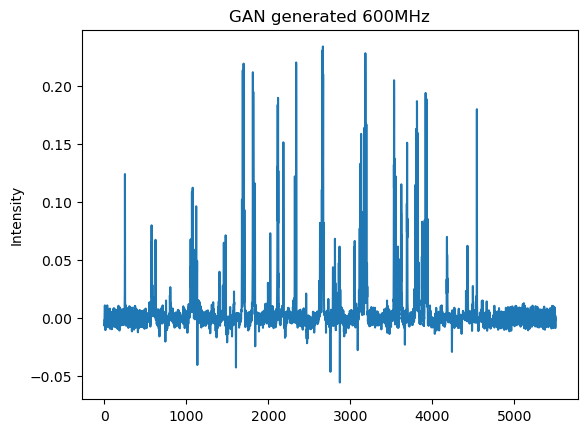

In [12]:
sb.lineplot(data=df_test[0])
plt.ylabel('Intensity')
plt.title('GAN generated 600MHz')

Text(0.5, 1.0, 'Actual 600MHz')

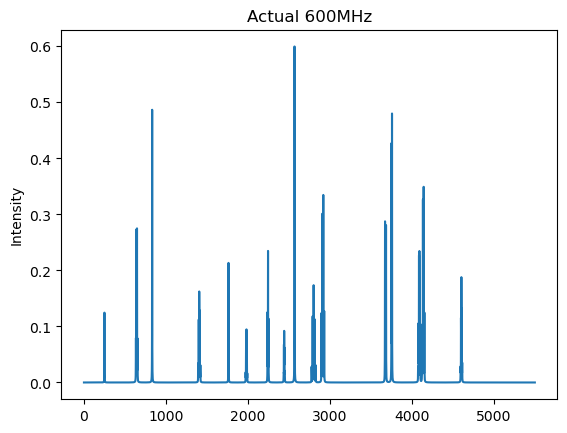

In [49]:
sb.lineplot(data=df_y[0])
plt.ylabel('Intensity')
plt.title('Actual 600MHz')

Text(0.5, 1.0, '60MHz')

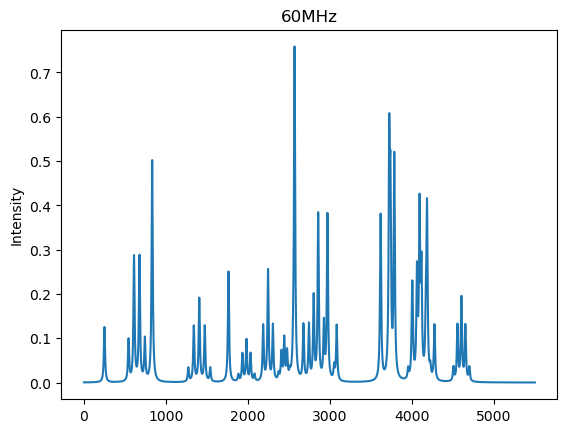

In [50]:
df_te=pd.DataFrame(x_test.numpy())
df_te=df_te.transpose()
sb.lineplot(data=df_te[0])
plt.ylabel('Intensity')
plt.title('60MHz')


Text(0.5, 1.0, '60MHz')

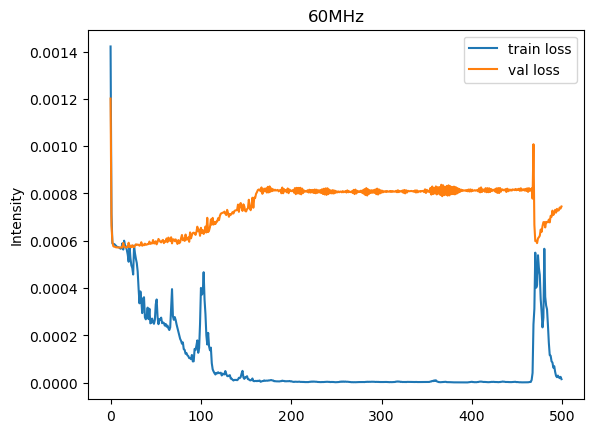

In [15]:
sb.lineplot(data=train_losses,label="train loss")
sb.lineplot(data=val_losses,label="val loss")
plt.ylabel('loss')
plt.title('60MHz')

Text(0.5, 1.0, '60MHz')

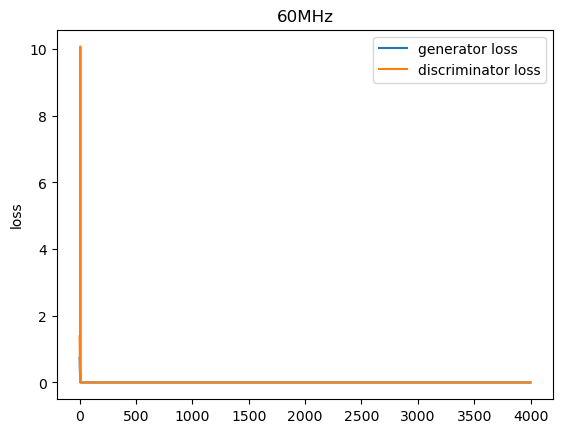

In [17]:
sb.lineplot(data=g_losses,label="generator loss")
sb.lineplot(data=d_losses,label="discriminator loss")
plt.ylabel('loss')
plt.title('60MHz')